In [28]:
import pandas as pd
import config
import seaborn

## Exploring CSV

In [2]:
csv_path='/Users/taoluo/Workspace/lorne/agltest/coding_practice_python_battery_dispatch_dataset.csv'

# read header from 1st line
df = pd.read_csv(config.CSV_PATH, header=0)

df.head()

,Timestamp,INITIALMW,TARGETMW,RRP
0,1/04/2024 0:05,0.0,0.0,59.66236
1,1/04/2024 0:10,0.0,0.0,59.75000
2,1/04/2024 0:15,0.0,0.0,59.20843
3,1/04/2024 0:20,0.0,0.0,59.59650
4,1/04/2024 0:25,0.0,0.0,58.49123


## Function to calculate interval revenue

### Asumption:
- As mentioned, INITIALMW and TARGETMW in each interval are linear ramping 
- intervals are fixed at 5 mins, so it hard coded below
- Discharging(positive MW) bring revenue, charging(negative MW) have no revenue but also no cost, this follows solar panel's battery

In [26]:
def calc_interval_discharge(initial, target):
    """calculate revenue in 5mins by initial and target"""
    # the ramp are under 0, indicate it's charing in whole interval, no revenue generated
    if initial <= 0 and target <= 0:
        return 0

    # the ramp above 0, calculate as trapezoid area
    if initial >= 0 and target >= 0:
        # (initial + target) / 12 / 2
        # / 12 for MWh in 5 mins
        # / 2 for  trapezoid area formula
        return (initial + target) / 24

    # the ramp across zero, only calculate the above 0 area
    charge_rate = max(initial, target)
    charge_ratio = abs(charge_rate) / (abs(initial) + abs(target))
    return charge_rate / 24 * charge_ratio

def calc_interval_charge(initial, target):
    return calc_interval_discharge(initial * -1, target * -1)

## Apply to Pandas 

Calculate revenue for each interval

In [27]:
calc_discharge = lambda row: calc_interval_discharge(row['INITIALMW'],row['TARGETMW'])
calc_charge = lambda row: calc_interval_charge(row['INITIALMW'],row['TARGETMW'])

df['discharge_power'] = df.apply(calc_discharge, axis=1)
df['charge_power'] = df.apply(calc_charge, axis=1)
df['revenue'] = df['RRP'] * df['discharge_power']
df.tail(100)

,Timestamp,INITIALMW,TARGETMW,RRP,revenue,discharge_power,charge_power
188,1/04/2024 15:45,0.00000,0.0,60.66444,0.000000,0.000000,0.000000
189,1/04/2024 15:50,1.13012,0.0,85.27446,4.015432,0.047088,0.000000
190,1/04/2024 15:55,-0.08866,-8.0,77.88982,0.000000,0.000000,0.337028
191,1/04/2024 16:00,-10.17502,0.0,63.17193,0.000000,0.000000,0.423959
192,1/04/2024 16:05,0.00000,0.0,49.99301,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
283,1/04/2024 23:40,-0.09306,0.0,65.90012,0.000000,0.000000,0.003878
284,1/04/2024 23:45,-0.09306,0.0,59.75000,0.000000,0.000000,0.003878
285,1/04/2024 23:50,-0.07211,0.0,59.55000,0.000000,0.000000,0.003005
286,1/04/2024 23:55,0.90866,0.0,61.92004,2.344344,0.037861,0.000000


## Get total revenue

**As calculation below, the total revenue is $8530.08**

In [9]:
total_revenue = sum(df['revenue'])
print(f'The total revenue in 1 Apr 2024 is ${total_revenue:.2f}')

The total revenue in 1 Apr 2024 is $8530.08


# Optional question: how should we measure the performance of the battery energy trading?

I calculated how much power is charged and discharged in the whole day, the chart below shows that this battery is primarily charged in the daytime and discharged at night, which matches how solar panels work.Lots of factors may impact solar panels (or batteries)'s including temperature, spectrum, sunlight etc.

In this case, we can simply compare the charged MWh and discharged MWh, **so the conversion rate of this battery conversion rate is 80.96%, accordingly the conversion loss is 19.04%**

Text(0.5, 1.0, 'charge and discharge')

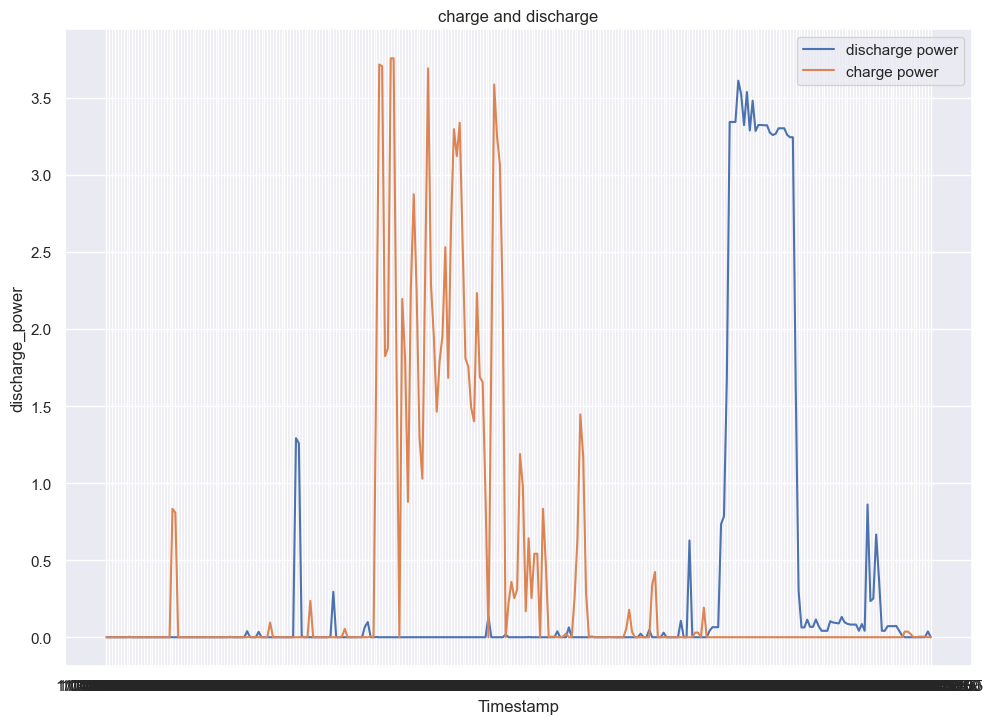

In [54]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
g=sns.lineplot(data=df,x='Timestamp', y="discharge_power", label = 'discharge power')
sns.lineplot(data=df,x='Timestamp', y="charge_power", label = 'charge power')

g.set_title('charge and discharge')

In [63]:
total_discharged = sum(df['discharge_power'])
total_charged = sum(df['charge_power'])
conversion_rate = total_discharged/total_charged
conversion_loss_rate = 1-conversion_rate
print(f'The battery conversion rate is {conversion_rate*100:.2f}%, the conversion loss is {conversion_loss_rate*100:.2f}%')



The battery conversion rate is 80.96%, the conversion loss is 19.04%
